# Analysis - Hashtag

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sps
import pandas as pd


from utils.cuda_cluster import *
from utils.dataset import read_data, factorize_small_cardinality

import core.config as conf


In [2]:
client

Client Scheduler: tcp://127.0.0.1:35501 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## 1. Load data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00175'
ori_df = read_data(data_path)

number of rows: 3033347


In [4]:
ori_df.columns

Index(['text_ tokens', 'hashtags', 'tweet_id', 'present_media',
       'present_links', 'present_domains', 'tweet_type', 'language',
       'tweet_timestamp', 'engaged_with_user_id',
       'engaged_with_user_follower_count', 'engaged_with_user_following_count',
       'engaged_with_user_is_verified', 'engaged_with_user_account_creation',
       'enaging_user_id', 'enaging_user_follower_count',
       'enaging_user_following_count', 'enaging_user_is_verified',
       'enaging_user_account_creation', 'engagee_follows_engager',
       'reply_timestamp', 'retweet_timestamp',
       'retweet_with_comment_timestamp', 'like_timestamp'],
      dtype='object')

In [102]:
df = ori_df[['engaged_with_user_id', 'engaged_with_user_follower_count', 'engaged_with_user_following_count', 'enaging_user_id', 'enaging_user_follower_count', 'enaging_user_following_count', 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp']]

In [103]:
df['is_reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['is_like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

df['is_positive'] = df['is_reply'] | df['is_retweet'] | df['is_comment'] | df['is_like']
df['is_negative'] =  df['is_positive'].compute().applymap(lambda x: 1 if x == 0 else 0).astype(np.int32)

df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)

In [104]:
total_users = dask_cudf.concat([ori_df["engaged_with_user_id"], ori_df["enaging_user_id"]]).unique().compute()
df, _ = factorize_small_cardinality(df, 'engaged_with_user_id', total_users, True)
df, _ = factorize_small_cardinality(df, 'enaging_user_id', total_users, True)

total_users

0          000000B946F21610D8169031348D6748
1          0000030E0DCCFDF9DBF2DDC031E6DA58
2          0000059852AB4CDFB4C417C550780C7D
3          000005BCF00DCCEABCF7F82BDCFB3543
4          0000079F3828E08D0A604E3E0D78C91F
                         ...               
3511085    FFFFF3D18C31109B40C431CE050BEE2E
3511086    FFFFF50BA9D4FF3225576C8996BE8BAC
3511087    FFFFF7DE6B3CB775180049CB3CD337BA
3511088    FFFFF8D0A1E9C84BD356965A0C74ADB8
3511089    FFFFFA8F28C6657BA57B88D608FA2298
Length: 3511090, dtype: object

In [105]:
df = df.rename(columns={'engaged_with_user_id_encode': 'creator_id'})
df = df.rename(columns={'enaging_user_id_encode': 'engager_id'})
df = df.drop('engaged_with_user_id', axis=1)
df = df.drop('enaging_user_id', axis=1)

df = df.rename(columns={'engaged_with_user_follower_count': 'creator_follower_count'})
df = df.rename(columns={'engaged_with_user_following_count': 'creator_following_count'})
df = df.rename(columns={'enaging_user_follower_count': 'engager_follower_count'})
df = df.rename(columns={'enaging_user_following_count': 'engager_following_count'})

In [106]:
df.head()

,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_id,engager_id
id,,,,,,,,,,,,
1,4753,1060,76,189,0,0,0,1,1,0,2586120,893844
2,110643,180,260,379,0,0,0,0,0,1,3355961,3173376
3,4480,2953,1259,868,1,0,0,0,1,0,1233947,951213
4,461,157,437,597,0,0,0,1,1,0,3063535,2013995
5,1308,1478,247,404,0,0,0,0,0,1,2280964,3018294


In [ ]:
df.compute().describe().astype(np.int64)

In [107]:
creator_engagements = df.groupby('creator_id')[['is_reply',	'is_retweet',	'is_comment',	'is_like',	'is_positive',	'is_negative']].sum().compute()
creator_engagements = creator_engagements.reset_index()
creator_engagements.head()

creator_follower_count = df.compute().groupby('creator_id')[['creator_follower_count']].nth(-1)
creator_follower_count = creator_follower_count.reset_index()

creator_following_count = df.compute().groupby('creator_id')[['creator_following_count']].nth(-1)
creator_following_count = creator_following_count.reset_index()

engager_follower_count = df.compute().groupby('creator_id')[['engager_follower_count']].nth(-1)
engager_follower_count = engager_follower_count.reset_index()

engager_following_count = df.compute().groupby('creator_id')[['engager_following_count']].nth(-1)
engager_following_count = engager_following_count.reset_index()


follow_count_df = creator_engagements.merge(creator_follower_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(creator_following_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(engager_follower_count, on=['creator_id'], how='left')
follow_count_df = follow_count_df.merge(engager_following_count, on=['creator_id'], how='left')



In [109]:
len(follow_count_df)

1558866

In [108]:
follow_count_df.head()

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
0,1059703,0,0,0,0,0,1,2354,4,224,621
1,1999004,1,0,0,0,1,0,1274,722,293,188
2,3329509,1,0,0,0,1,0,221,294,79,83
3,97511,0,1,0,0,1,0,328,231,1765,676
4,1636915,0,0,0,0,0,1,1596,586,665,494


In [113]:
follow_count_df.describe().astype(np.int64)

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
count,1558866,1558866,1558866,1558866,1558866,1558866,1558866,1558866,1558866,1558866,1558866
mean,1755430,0,0,0,0,0,0,28492,1820,942,765
std,1013549,0,1,0,4,5,4,460536,12494,11151,1758
min,4,0,0,0,0,0,0,1,0,0,1
25%,877468,0,0,0,0,0,0,359,221,99,166
50%,1755200,0,0,0,0,1,1,1139,532,271,359
75%,2633364,0,0,0,1,1,1,4624,1288,711,791
max,3511089,126,474,36,1324,1529,1080,129240509,4256371,5211678,402187


## 2. creator - follower count

In [114]:
sorted_creator_follower = follow_count_df.sort_values('creator_follower_count', ascending=False)

top_n = 10000
top_n_creator = sorted_creator_follower[:top_n]
top_n_creator.describe().astype(np.int64)

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1757863,0,2,0,11,14,19,2576096,16862,1173,620
std,1006794,1,8,0,43,49,41,5119106,119548,40308,886
min,355,0,0,0,0,0,0,660258,0,0,1
25%,894605,0,0,0,0,0,2,886058,118,48,154
50%,1762141,0,0,0,2,2,7,1297953,446,149,334
75%,2623967,0,1,0,7,9,19,2370300,1208,400,708
max,3511046,45,228,33,1324,1529,1080,129240509,4256371,3793017,19895


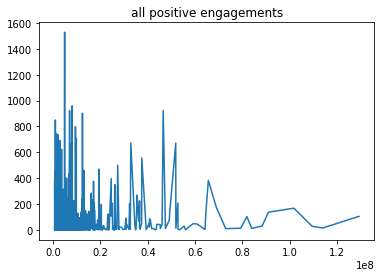

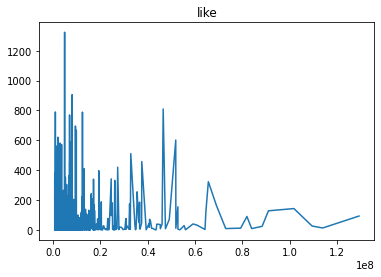

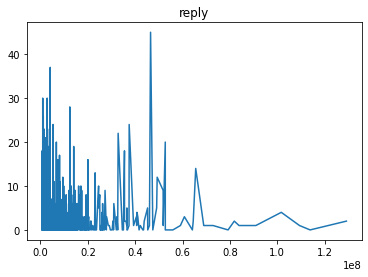

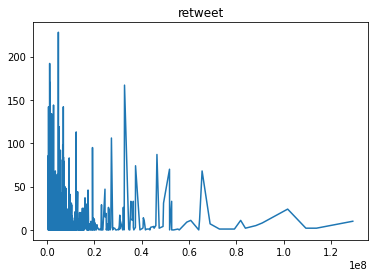

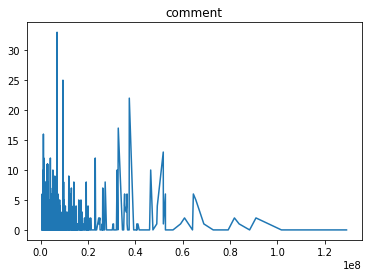

In [115]:
plt.title('all positive engagements')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_creator['creator_follower_count'].to_array(), top_n_creator['is_comment'].to_array())
plt.show()

## 3. creator - following count

In [116]:
sorted_creator_following = follow_count_df.sort_values('creator_following_count', ascending=False)

top_n = 10000
top_n_creator = sorted_creator_following[:top_n]
top_n_creator.describe().astype(np.int64)

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1746004,0,0,0,1,2,3,237577,80860,2069,1896
std,1013877,0,2,0,10,12,9,2385634,130952,9285,6680
min,32,0,0,0,0,0,0,17259,26199,0,4
25%,881858,0,0,0,0,0,1,40546,32604,233,340
50%,1737657,0,0,0,0,0,1,65950,45146,655,809
75%,2621197,0,0,0,1,1,3,131317,76978,1700,1990
max,3510922,74,198,21,437,637,488,129240509,4256371,536690,402187


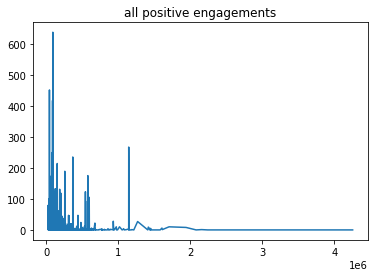

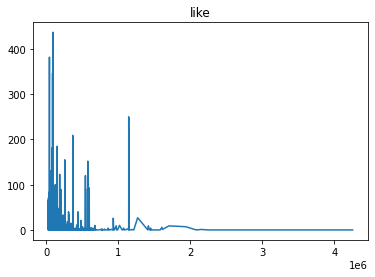

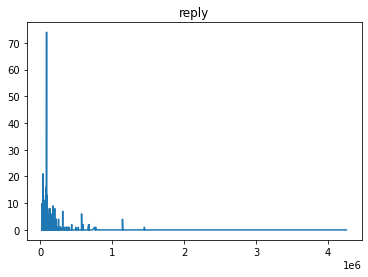

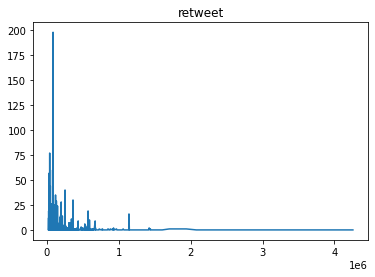

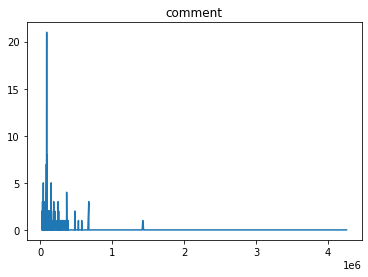

In [117]:
plt.title('all positive engagements')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_creator['creator_following_count'].to_array(), top_n_creator['is_comment'].to_array())
plt.show()

## 4. engager - follower count

In [118]:
sorted_engager_follower = follow_count_df.sort_values('engager_follower_count', ascending=False)

top_n = 10000
top_n_engager = sorted_engager_follower[:top_n]
top_n_engager.describe().astype(np.int64)

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1755166,0,0,0,0,0,0,26167,4216,40657,9227
std,1019096,0,0,0,3,3,3,279993,16190,132481,15398
min,765,0,0,0,0,0,0,6,0,13111,3
25%,868781,0,0,0,0,0,0,1212,514,15693,946
50%,1757570,0,0,0,0,0,1,3601,1256,20609,3824
75%,2642825,0,0,0,1,1,1,11586,3539,32705,13814
max,3510747,17,39,5,234,284,317,16839400,516800,5211678,402187


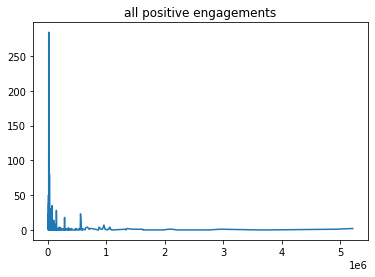

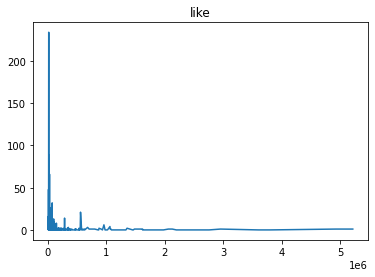

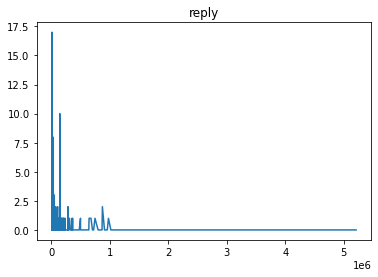

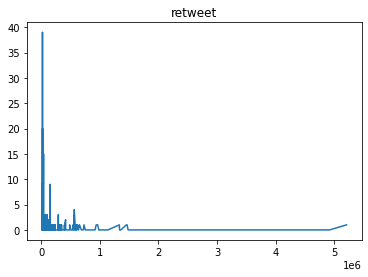

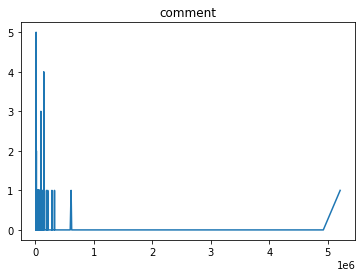

In [119]:
plt.title('all positive engagements')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_engager['engager_follower_count'].to_array(), top_n_engager['is_comment'].to_array())
plt.show()

## 5. engager - following count

In [120]:
sorted_engager_following = follow_count_df.sort_values('engager_following_count', ascending=False)

top_n = 10000
top_n_engager = sorted_engager_following[:top_n]
top_n_engager.describe().astype(np.int64)

,creator_id,is_reply,is_retweet,is_comment,is_like,is_positive,is_negative,creator_follower_count,creator_following_count,engager_follower_count,engager_following_count
count,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
mean,1757529,0,0,0,0,0,0,13898,6803,17946,13413
std,1019029,0,0,0,2,3,2,178752,23121,31168,13684
min,10,0,0,0,0,0,0,9,0,1780,6892
25%,870310,0,0,0,0,0,0,1174,1023,8911,8080
50%,1757872,0,0,0,0,0,1,3144,2773,11728,9974
75%,2642611,0,0,0,1,1,1,8264,5643,17754,13883
max,3510747,3,30,4,209,235,255,16517617,1072339,1334647,402187


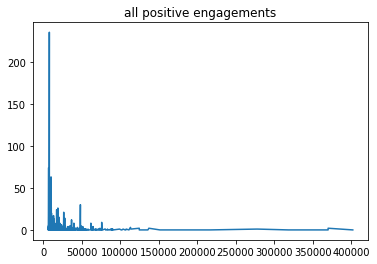

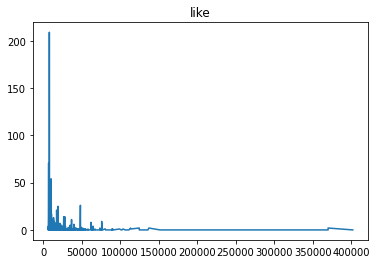

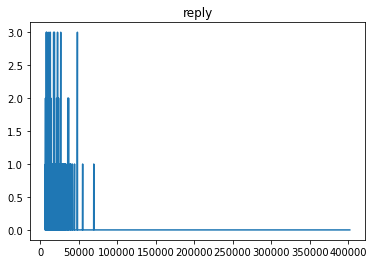

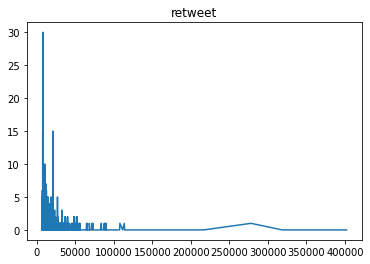

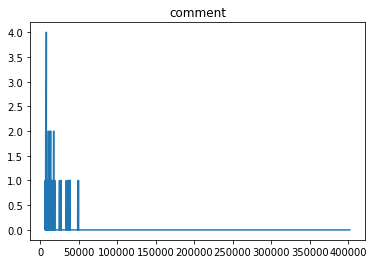

In [121]:
plt.title('all positive engagements')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_positive'].to_array())
plt.show()

plt.title('like')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_like'].to_array())
plt.show()

plt.title('reply')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_reply'].to_array())
plt.show()

plt.title('retweet')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_retweet'].to_array())
plt.show()

plt.title('comment')
plt.plot(top_n_engager['engager_following_count'].to_array(), top_n_engager['is_comment'].to_array())
plt.show()

## 6. The (creator/engager)'s (follower/following) count of popular tweets